In [1]:
import json 
import numpy as np
import matplotlib.pyplot as plt
import glob 
from dataclasses import dataclass
import pandas as pd


In [2]:
@dataclass 
class ModelGeneration:
    model_path: str 
    question_num: int
    sample_num: int
    generation: str 
    embedding: list 


def load_generations(file_path):

    with open(file_path, 'r') as f:
        data = json.load(f)

    return ModelGeneration(
        model_path=file_path.split('/')[-2],
        question_num=data['question_id'],
        sample_num=data['sample_index'],
        generation=data['converted_text'],
        embedding=data['converted_embedding']
        # embedding=data['generated_embedding']
    )

# ADD base
model_names = ['taco_instruct_llama_8b_single', 'taco_instruct_llama_8b_single_slerp_0.7', 'taco_instruct_llama_8b_single_slerp_0.90', 'taco_instruct_llama_8b_single_slerp_0.5']
generations = []

for model_name in model_names:
    model_path = f"/scratch/gpfs/vv7118/projects/messi-thinking/embeddings/{model_name}"
    model_files = glob.glob(f"{model_path}/converted_*.json")
    for file_path in model_files:
        try: 
            generations.append(load_generations(file_path))
        except Exception as e:
            print(f"Error loading file {file_path}: {e}")



In [3]:
def calculate_cosine_similarities(df, model_name):
    """Calculate cosine similarities between all rows for a specific model."""
    # Filter for the specific model
    model_df = df[df['model_path'] == model_name].copy()
    
    embeddings = np.array([np.array(emb) for emb in model_df['embedding']])
    similarity_matrix = np.dot(embeddings, embeddings.T)
    sims = similarity_matrix.mean(axis=1)
    model_df['avg_question_similarity'] = sims
    return model_df

In [4]:
def calculate_same_question_similarities(df, model_name):
    """Calculate mean cosine similarities between generations of the same question."""
    model_df = df[df['model_path'] == model_name].copy()
    question_groups = model_df.groupby('question_num')
    
    results = []
    
    for question_num, group in question_groups:
        if len(group) <= 1:
            continue
        embeddings = np.array([np.array(emb) for emb in group['embedding']])
        
        norms = np.linalg.norm(embeddings, axis=1)
        
        normalized_embeddings = embeddings / norms[:, np.newaxis]
        
        similarity_matrix = np.dot(normalized_embeddings, normalized_embeddings.T)
        
        np.fill_diagonal(similarity_matrix, 0)
        
        mean_similarity = similarity_matrix.sum() / (len(group) * (len(group) - 1))
        
        results.append({
            'question_num': question_num,
            'num_samples': len(group),
            'mean_similarity': mean_similarity
        })
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    return results_df
    

In [5]:
df = pd.DataFrame(generations)
df = df[df['question_num'] < 1000]
df = df[df['sample_num'] < 11]

In [6]:
df['str_len'] = df['generation'].str.len()
df['str_len_bucket'] = pd.qcut(df['str_len'], q=10, labels=False)

In [7]:
# avg str len diff per qs 
qs = df.groupby(['model_path', 'question_num'])['str_len'].mean().reset_index()
qs = qs.pivot(index='question_num', columns='model_path', values='str_len')
qs['diff'] = qs['taco_instruct_llama_8b_single'] - qs['taco_instruct_llama_8b_single_slerp_0.7']
qs['diff_0.90'] = qs['taco_instruct_llama_8b_single'] - qs['taco_instruct_llama_8b_single_slerp_0.90']
print(qs['diff'].mean())
print(qs['diff_0.90'].mean())


4672.578159285426
9134.830029007984


In [8]:
qs_to_limit_to = qs[qs['diff'].abs() < 500].index.tolist()

In [9]:
df_temp = df[df['question_num'].isin(qs_to_limit_to)]


In [10]:
df1 = calculate_cosine_similarities(df, 'taco_instruct_llama_8b_single')
df2 = calculate_cosine_similarities(df, 'taco_instruct_llama_8b_single_slerp_0.7')
df3 = calculate_cosine_similarities(df, 'taco_instruct_llama_8b_single_slerp_0.90')
df4 = calculate_cosine_similarities(df, 'taco_instruct_llama_8b_single_slerp_0.5')
# df5 = calculate_cosine_similarities(df, 'taco_medium_llama_8b_messy_reasoning_not_blind')


In [8]:
pd.concat([df1, df2, df3, df4], axis=0).groupby(['model_path'])['avg_question_similarity'].mean()


NameError: name 'df1' is not defined

In [12]:
name_mapping = {
    "llama_8b_single": "$\\alpha=1$",
    "llama_8b_slerp_0.90": "$\\alpha=0.9$",
    "llama_8b_slerp_0.70": "$\\alpha=0.7$",
    "llama_8b_slerp_0.50": "$\\alpha=0.5$",
    # "messy_reasoning_not_blind": "Mixed (300-50)"
}

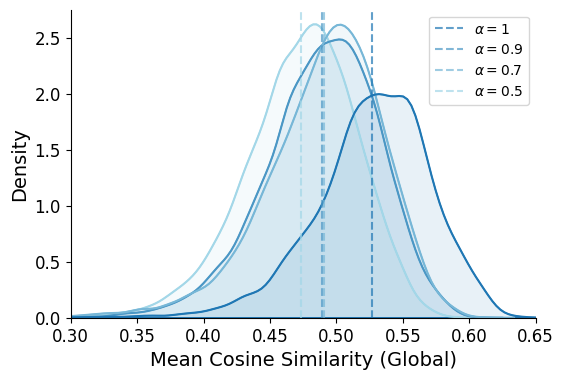

In [13]:
import seaborn as sns
model_colors = {
    'llama_8b_single': '#1f77b4',  # blue
    'llama_8b_slerp_0.90': '#2ca02c',  # green
    'llama_8b_slerp_0.70': '#ff7f0e',  # orange
    'llama_8b_slerp_0.50': '#9467bd',  # purple
    # 'messy_reasoning_not_blind': '#d62728'  # red
}
model_colors = {
    'llama_8b_single': '#1f77b4',        # darkest blue
    'llama_8b_slerp_0.90': '#4b97c5',    # slightly lighter blue
    'llama_8b_slerp_0.70': '#77b7d7',    # lighter blue
    'llama_8b_slerp_0.50': '#a3d7e8',    # lightest blue
    # 'messy_reasoning_not_blind': '#d62728'          # red
}
# model_colors = {
#     'llama_8b_single': '#1f77b4',        # blue
#     'llama_8b_slerp_0.90': '#d62728',    # red
#     'llama_8b_slerp_0.70': '#9467bd',    # purple
#     'llama_8b_slerp_0.50': '#1f77b4',    # blue
#     'messy_reasoning': '#2ca02c'          # green
# }

plot_data = pd.concat([
    pd.DataFrame({
        'similarity': df1['avg_question_similarity'],
        'model': 'llama_8b_single'
    }),
    pd.DataFrame({
        'similarity': df2['avg_question_similarity'],
        'model': 'llama_8b_slerp_0.70'
    }),
    pd.DataFrame({
        'similarity': df3['avg_question_similarity'],
        'model': 'llama_8b_slerp_0.90'
    }),
    pd.DataFrame({
        'similarity': df4['avg_question_similarity'],
        'model': 'llama_8b_slerp_0.50'
    }),
    # pd.DataFrame({
    #     'similarity': df5['avg_question_similarity'],
    #     'model': 'messy_reasoning_not_blind'
    # }),
])

# Create the plot
plt.figure(figsize=(6, 4))
sns.kdeplot(data=plot_data, x='similarity', hue='model', fill=True, alpha=0.1, palette=model_colors)
sns.kdeplot(data=plot_data, x='similarity', hue='model', fill=False, alpha=1, palette=model_colors)#
# plt.title('Similarities by Model', fontsize=15)
plt.xlabel('Mean Cosine Similarity (Global)', fontsize=14)
plt.ylabel('Density', fontsize=14)

for model, color in model_colors.items():
    if model == 'llama_8b_single':
        mean = df1['avg_question_similarity'].mean()
    elif model == 'llama_8b_slerp_0.70':
        mean = df2['avg_question_similarity'].mean()
    elif model == 'llama_8b_slerp_0.90':
        mean = df3['avg_question_similarity'].mean()
    elif model == 'llama_8b_slerp_0.50':
        mean = df4['avg_question_similarity'].mean()
    # elif model == 'messy_reasoning_not_blind':
    #     mean = df5['avg_question_similarity'].mean()
    
    plt.axvline(mean, color=color, linestyle='--', alpha=.7, linewidth=1.5,
               label=f'{name_mapping[model]}')
plt.xlim(0.3, 0.65)  # Add this line to limit x-axis

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)    
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)


plt.legend(fontsize=10)
plt.savefig('avg_question_similarity.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
pd.concat([df1, df2], axis=0).groupby(['model_path', 'str_len_bucket'])['avg_question_similarity'].mean()


model_path                               str_len_bucket
taco_instruct_llama_8b_single            0                 0.402124
                                         1                 0.498484
                                         2                 0.509625
                                         3                 0.523356
                                         4                 0.528138
                                         5                 0.530215
                                         6                 0.532689
                                         7                 0.529797
                                         8                 0.528760
                                         9                 0.525328
taco_instruct_llama_8b_single_slerp_0.7  0                 0.421998
                                         1                 0.472741
                                         2                 0.483092
                                         3                 0

In [15]:
m1 = calculate_same_question_similarities(df, 'taco_instruct_llama_8b_single')
m2 =calculate_same_question_similarities(df, 'taco_instruct_llama_8b_single_slerp_0.7')
m3 = calculate_same_question_similarities(df, 'taco_instruct_llama_8b_single_slerp_0.90')
m4 = calculate_same_question_similarities(df, 'taco_instruct_llama_8b_single_slerp_0.5')
# m5 = calculate_same_question_similarities(df, 'taco_medium_llama_8b_messy_reasoning_not_blind')

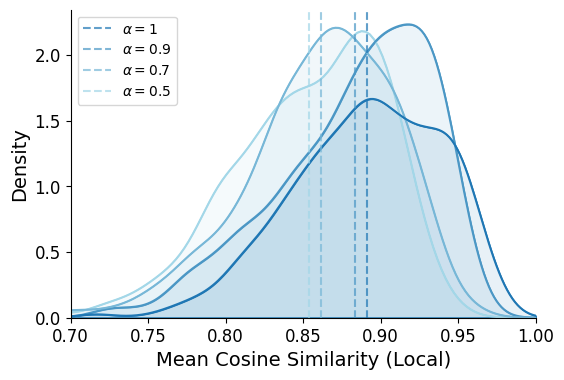

In [16]:
import seaborn as sns
plot_data = pd.concat([
    pd.DataFrame({
        'similarity': m1['mean_similarity'],
        'model': 'llama_8b_single'
    }),
    # pd.DataFrame({
    #     'similarity': m5['mean_similarity'],
    #     'model': 'messy_reasoning_not_blind'
    # }),
    pd.DataFrame({
        'similarity': m2['mean_similarity'],
        'model': 'llama_8b_slerp_0.70'
    }),
    pd.DataFrame({
        'similarity': m3['mean_similarity'],
        'model': 'llama_8b_slerp_0.90'
    }),
    pd.DataFrame({
        'similarity': m4['mean_similarity'],
        'model': 'llama_8b_slerp_0.50'
    }),
])

# Create the plot
plt.figure(figsize=(6, 4))
sns.kdeplot(data=plot_data, x='similarity', hue='model', fill=True, alpha=0.1, palette=model_colors)
sns.kdeplot(data=plot_data, x='similarity', hue='model', fill=False, alpha=1, palette=model_colors)# plt.title('Same-Question Similarities by Model', fontsize=15)
plt.xlabel('Mean Cosine Similarity (Local)', fontsize=14)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.ylabel('Density', fontsize=14)
model_means = {
    'llama_8b_single': m1['mean_similarity'].mean(),
    'llama_8b_slerp_0.90': m3['mean_similarity'].mean(),
    'llama_8b_slerp_0.70': m2['mean_similarity'].mean(),
    'llama_8b_slerp_0.50': m4['mean_similarity'].mean(),
    # 'messy_reasoning_not_blind': m5['mean_similarity'].mean(),
}
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0.7, 1.0)  # Add this line to limit x-axis


for model, mean in model_means.items():
    plt.axvline(mean, color=model_colors[model], linestyle='--', alpha=.7, linewidth=1.5,
               label=f'{name_mapping[model]}')
plt.legend(fontsize=10)
plt.savefig('avg_same_question_similarity.pdf', dpi=300, bbox_inches='tight')

plt.show()

